# Putting the "Re" in Reformer: Ungraded Lab
This ungraded lab will explore Reversible Residual Networks. You will use these networks in this week's assignment that utilizes the Reformer model. It is based on the Transformer model you already know, but with two unique features.
* Locality Sensitive Hashing (LSH) Attention to reduce the compute cost of the dot product attention and
* Reversible Residual Networks (RevNets) organization to reduce the storage requirements when doing backpropagation in training.

In this ungraded lab we'll start with a quick review of Residual Networks and their implementation in Trax. Then we will discuss the Revnet architecture and its use in Reformer.
## Outline
- [Part 1:  Residual Networks](#1)
    - [1.1  Branch](#1.1)
    - [1.2  Residual Model](#1.2)
- [Part 2:  Reversible Residual Networks](#2)
    - [2.1  Trax Reversible Layers](#2.1)
    - [2.2  Residual Model](#2.2)




In [1]:
import trax
from trax import layers as tl               # core building block
import numpy as np                          # regular ol' numpy
from trax.layers.reversible import (
    ReversibleHalfResidual,
)                                           # unique spot
from trax import fastmath                   # uses jax, offers numpy on steroids
from trax import shapes                     # data signatures: dimensionality and type
from trax.fastmath import numpy as jnp      # For use in defining new layer types.
from trax.shapes import ShapeDtype
from trax.shapes import signature

!pip list|grep trax

trax                         1.3.9
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


## Part 1.0  Residual Networks
[Deep Residual Networks ](https://arxiv.org/abs/1512.03385) (Resnets) were introduced to improve convergence in deep networks. Residual Networks introduce a shortcut connection around one or more layers in a deep network as shown in the diagram below from the original paper.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>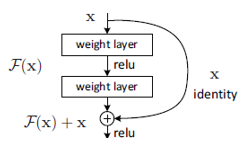</body></html>
<center><img src = "images/Revnet7.PNG" height="250" width="250"></center>
<center><b>Figure 1: Residual Network diagram from original paper</b></center>

The [Trax documentation](https://trax-ml.readthedocs.io/en/latest/notebooks/layers_intro.html#2.-Inputs-and-Outputs) describes an implementation of Resnets using `branch`. We'll explore that here by implementing a simple resnet built from simple function based layers. Specifically, we'll build a 4 layer network based on two functions, 'F' and 'G'.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>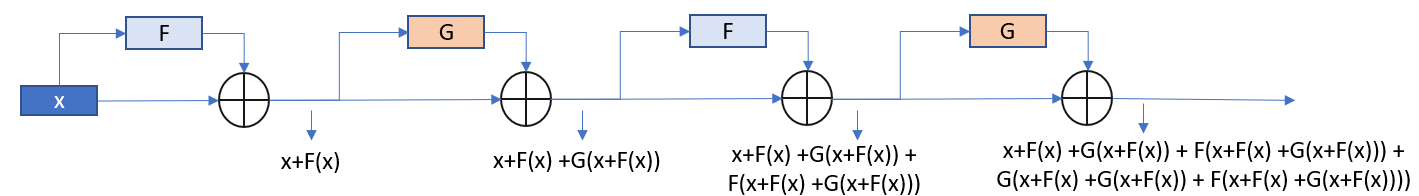</body></html>
<img src = "images/Revnet8.PNG" height="200" width="1400">
<center><b>Figure 2: 4 stage Residual network</b></center>
Don't worry about the lengthy equations. Those are simply there to be referenced later in the notebook.

<a name="1.1"></a>
### Part 1.1  Branch
Trax `branch` figures prominently in the residual network layer so we will first examine it. You can see from the figure above that we will need a function that will copy an input and send it down multiple paths. This is accomplished with a  [branch layer](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#module-trax.layers.combinators), one of the Trax 'combinators'. Branch is a combinator that applies a list of layers in parallel to copies of inputs. Lets try it out!  First we will need some layers to play with. Let's build some from functions.

In [2]:
# simple function taking one input and one output
bl_add1 = tl.Fn("add1", lambda x0: (x0 + 1), n_out=1)
bl_add2 = tl.Fn("add2", lambda x0: (x0 + 2), n_out=1)
bl_add3 = tl.Fn("add3", lambda x0: (x0 + 3), n_out=1)
# try them out
x = np.array([1])
print(bl_add1(x), bl_add2(x), bl_add3(x))
# some information about our new layers
print(
    "name:",
    bl_add1.name,
    "number of inputs:",
    bl_add1.n_in,
    "number of outputs:",
    bl_add1.n_out,
)

[2] [3] [4]
name: add1 number of inputs: 1 number of outputs: 1


In [3]:
bl_3add1s = tl.Branch(bl_add1, bl_add2, bl_add3)
bl_3add1s

Branch_out3[
  add1
  add2
  add3
]

Trax uses the concept of a 'stack' to transfer data between layers.
For Branch, for each of its layer arguments, it copies the `n_in` inputs from the stack and provides them to the layer, tracking the max_n_in, or the largest n_in required. It then pops the max_n_in elements from the stack.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>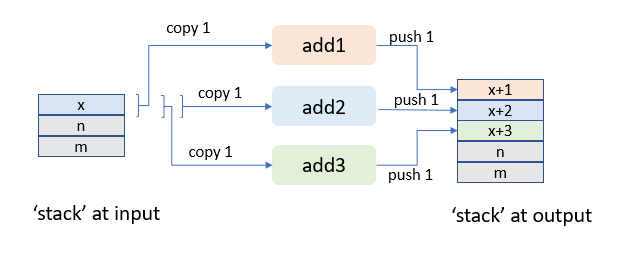</body></html>
<img src = "images/branch1.PNG" height="260" width="600">
<center><b>Figure 3: One in, one out Branch</b></center>
On output, each layer, in succession pushes its results onto the stack. Note that the push/pull operations impact the top of the stack. Elements that are not part of the operation (n, and m in the diagram) remain intact.

In [4]:
# n_in = 1, Each bl_addx pushes n_out = 1 elements onto the stack
bl_3add1s(x)

(array([2]), array([3]), array([4]))

In [5]:
# n = np.array([10]); m = np.array([20])  # n, m will remain on the stack
n = "n"
m = "m"  # n, m will remain on the stack
bl_3add1s([x, n, m]) 

(array([2]), array([3]), array([4]), 'n', 'm')

Each layer in the input list copies as many inputs from the stack as it needs, and their outputs are successively combined on stack. Put another way, each element of the branch can have differing numbers of inputs and outputs. Let's try a more complex example.

In [21]:
bl_addab = tl.Fn(
    "addab", lambda x0, x1: (x0 + x1), n_out=1
)  # Trax figures out how many inputs there are
bl_rep3x = tl.Fn(
    "add2x", lambda x0: (x0, x0, x0), n_out=3
)  # but you have to tell it how many outputs there are
bl_3ops = tl.Branch(bl_add1, bl_addab, bl_rep3x)

In this case, the number of inputs being copied from the stack varies with the layer
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>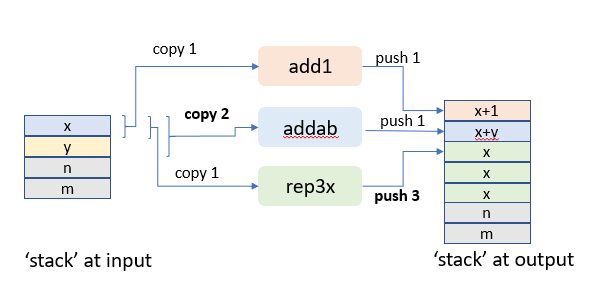</body></html>
<img src = "images/branch2.PNG" height="260" width="600">
<center><b>Figure 4: variable in, variable out Branch</b></center>
The stack when the operation is finished is 5 entries reflecting the total from each layer.

In [7]:
# Before Running this cell, what is the output you are expecting?
y = np.array([3])
bl_3ops([x, y, n, m])

(array([2]), array([4]), array([1]), array([1]), array([1]), 'n', 'm')

Branch has a special feature to support Residual Network. If an argument is 'None', it will pull the top of stack  and push it (at its location in the sequence) onto the output stack
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>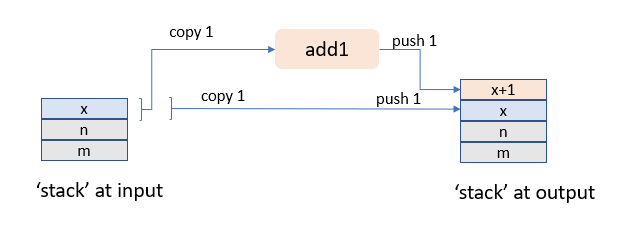</body></html>
<img src = "images/branch3.PNG" height="260" width="600">
<center><b>Figure 5: Branch for Residual</b></center>

In [8]:
bl_2ops = tl.Branch(bl_add1, None)
bl_2ops([x, n, m])

(array([2]), array([1]), 'n', 'm')

<a name="1.2"></a>
### Part 1.2  Residual Model
OK, your turn. Write a function 'MyResidual', that uses `tl.Branch` and `tl.Add` to build a residual layer. If you are curious about the Trax implementation, you can see the code [here](https://github.com/google/trax/blob/190ec6c3d941d8a9f30422f27ef0c95dc16d2ab1/trax/layers/combinators.py).

In [9]:
def MyResidual(layer):
    return tl.Serial(
        ### START CODE HERE ###
        # tl.----,
        # tl.----,
        ### END CODE HERE ###
    )

In [10]:
# Lets Try it
mr = MyResidual(bl_add1)
x = np.array([1])
mr([x, n, m])

[array([1]), 'n', 'm']

**Expected Result**
(array([3]), 'n', 'm')

Great! Now, let's build the 4 layer residual Network in Figure 2. You can use `MyResidual`, or if you prefer, the tl.Residual in Trax, or a combination!

In [11]:
Fl = tl.Fn("F", lambda x0: (2 * x0), n_out=1)
Gl = tl.Fn("G", lambda x0: (10 * x0), n_out=1)
x1 = np.array([1])

In [12]:
resfg = tl.Serial(
    ### START CODE HERE ###
    # None,  #Fl    # x + F(x)
    # None,  #Gl    # x + F(x) + G(x + F(x)) etc
    # None,  #Fl
    # None,  #Gl
    ### END CODE HERE ###
)

In [13]:
# Lets try it
resfg([x1, n, m])

[array([1]), 'n', 'm']

**Expected Results**
(array([1089]), 'n', 'm')

<a name="2"></a>
## Part 2.0 Reversible Residual Networks
The Reformer utilized RevNets to reduce the storage requirements for performing backpropagation.
<img src = "images/Reversible2.PNG" height="260" width="600">
<center><b>Figure 6: Reversible Residual Networks </b></center>
The standard approach on the left above requires one to store the outputs of each stage for use during backprop. By using the organization to the right, one need only store the outputs of the last stage, y1, y2 in the diagram. Using those values and running the algorithm in reverse, one can reproduce the values required for backprop. This trades additional computation for memory space which is at a premium with the current generation of GPU's/TPU's.

One thing to note is that the forward functions produced by two networks are similar, but they are not equivalent. Note for example the asymmetry in the output equations after two stages of operation.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>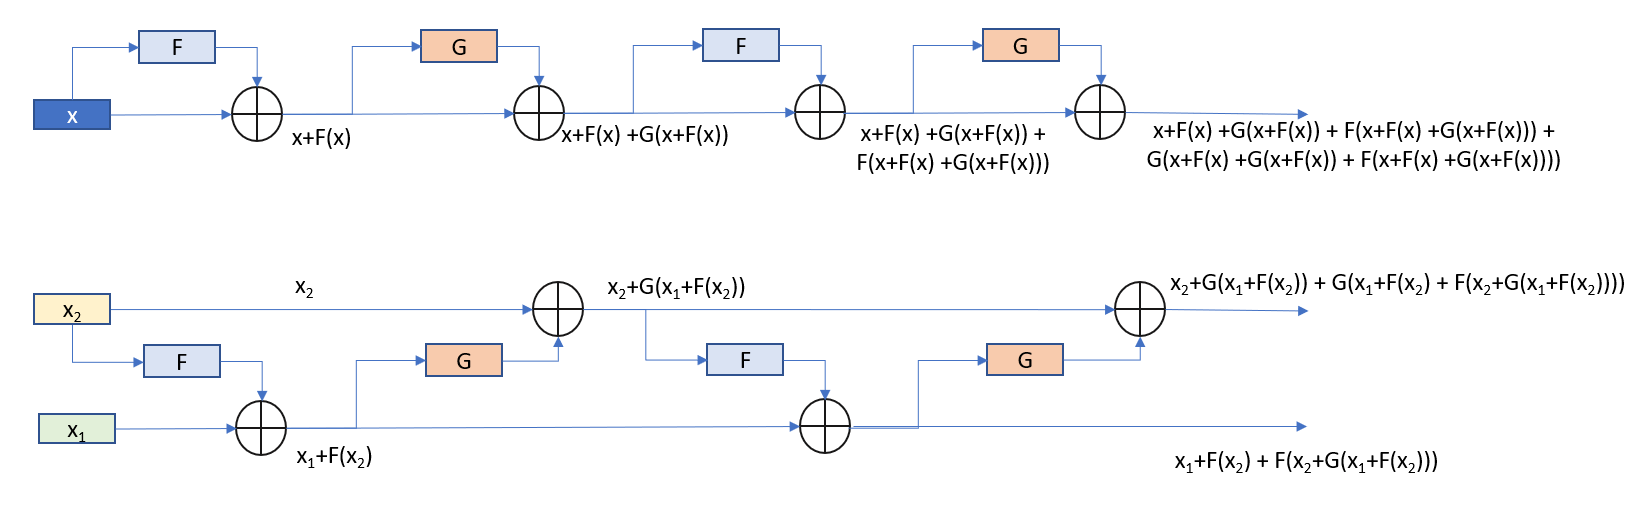</body></html>
<img src = "images/Revnet1.PNG" height="340" width="1100">
<center><b>Figure 7: 'Normal' Residual network (Top) vs REversible Residual Network </b></center>

### Part 2.1  Trax Reversible Layers

Let's take a look at how this is used in the Reformer.

In [14]:
refm = trax.models.reformer.ReformerLM(
    vocab_size=33000, n_layers=2, mode="train"  # Add more options.
)
refm

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_33000_512
  Dropout
  Serial[
    PositionalEncoding
  ]
  Dup_out2
  ReversibleSerial_in2_out2[
    ReversibleHalfResidualDecoderAttn_in2_out2[
      Serial[
        LayerNorm
      ]
      SelfAttention
    ]
    ReversibleSwap_in2_out2
    ReversibleHalfResidualDecoderFF_in2_out2[
      Serial[
        LayerNorm
        Dense_2048
        Dropout
        Serial[
          FastGelu
        ]
        Dense_512
        Dropout
      ]
    ]
    ReversibleSwap_in2_out2
    ReversibleHalfResidualDecoderAttn_in2_out2[
      Serial[
        LayerNorm
      ]
      SelfAttention
    ]
    ReversibleSwap_in2_out2
    ReversibleHalfResidualDecoderFF_in2_out2[
      Serial[
        LayerNorm
        Dense_2048
        Dropout
        Serial[
          FastGelu
        ]
        Dense_512
        Dropout
      ]
    ]
    ReversibleSwap_in2_out2
  ]
  Concatenate_in2
  LayerNorm
  Dropout
  Serial[
    Dense_33000
  ]
]

Eliminating some of the detail, we can see the structure of the network.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>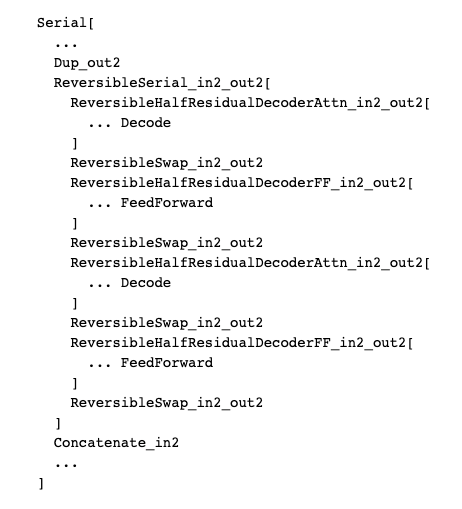</body></html>
<img src = "images/Revnet2.PNG" height="300" width="350">
<center><b>Figure 8: Key Structure of Reformer Reversible Network Layers in Trax </b></center>

We'll review the Trax layers used to implement the Reversible section of the Reformer. First we can note that not all of the reformer is reversible. Only the section in the ReversibleSerial layer is reversible. In a large Reformer model, that section is repeated many times making up the majority of the model.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>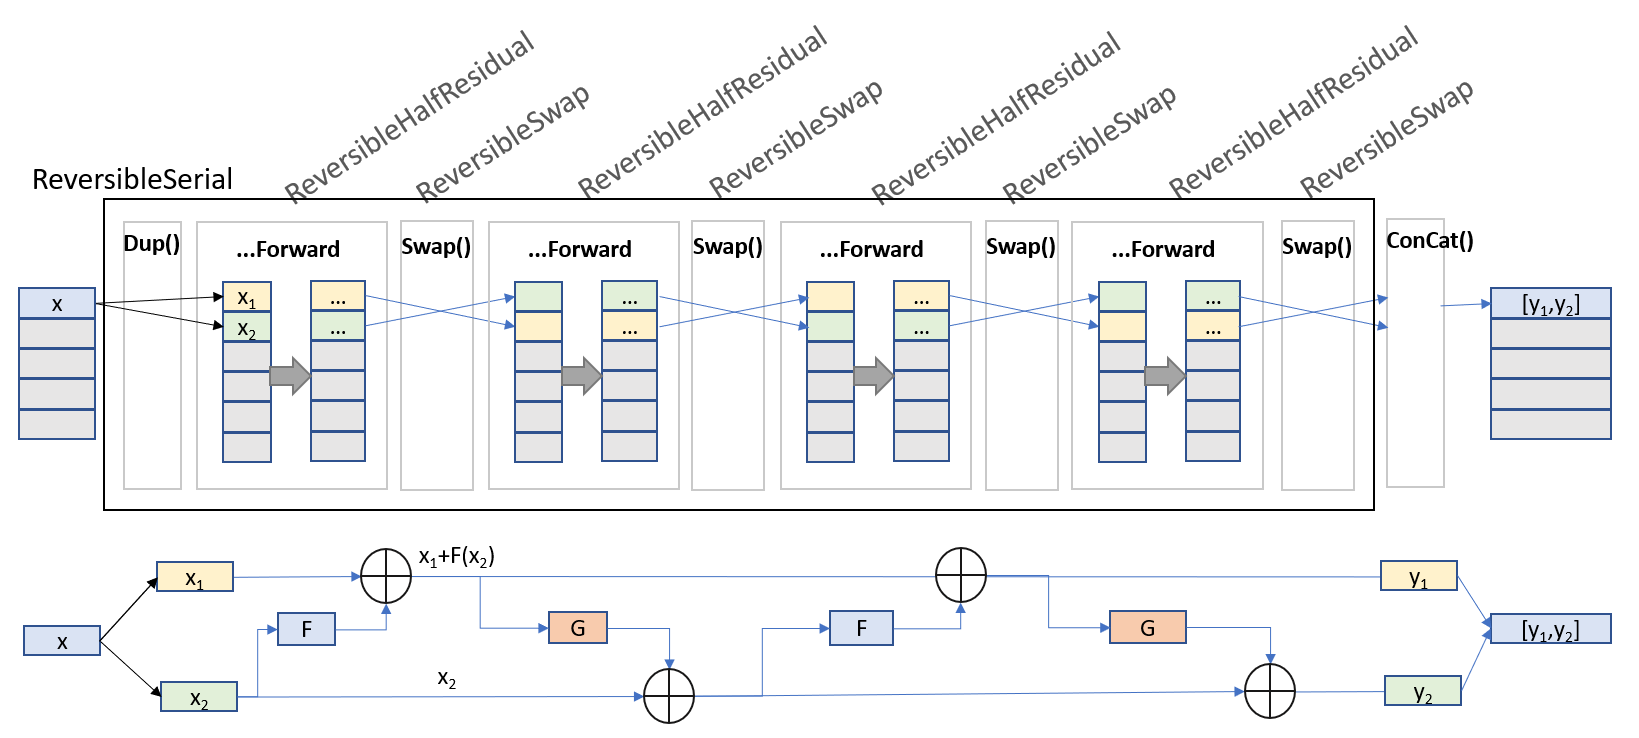</body></html>
<img src = "images/Revnet3.PNG" height="650" width="1600">
<center><b>Figure 9: Functional Diagram of Trax elements in Reformer </b></center>

The implementation starts by duplicating the input to allow the two paths that are part of the reversible residual organization with [Dup](https://github.com/google/trax/blob/190ec6c3d941d8a9f30422f27ef0c95dc16d2ab1/trax/layers/combinators.py#L666). Note that this is accomplished by copying the top of stack and pushing two copies of it onto the stack. This then feeds into the ReversibleHalfResidual layer which we'll review in more detail below. This is followed by [ReversibleSwap](https://github.com/google/trax/blob/190ec6c3d941d8a9f30422f27ef0c95dc16d2ab1/trax/layers/reversible.py#L83). As the name implies, this performs a swap, in this case, the two topmost entries in the stack. This pattern is repeated until we reach the end of the ReversibleSerial section. At that point, the topmost 2 entries of the stack represent the two paths through the network. These are concatenated and pushed onto the stack. The result is an entry that is twice the size of the non-reversible version.

Let's look more closely at the [ReversibleHalfResidual](https://github.com/google/trax/blob/190ec6c3d941d8a9f30422f27ef0c95dc16d2ab1/trax/layers/reversible.py#L154). This layer is responsible for executing the layer or layers provided as arguments and adding the output of those layers, the 'residual', to the top of the stack. Below is the 'forward' routine which implements this.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>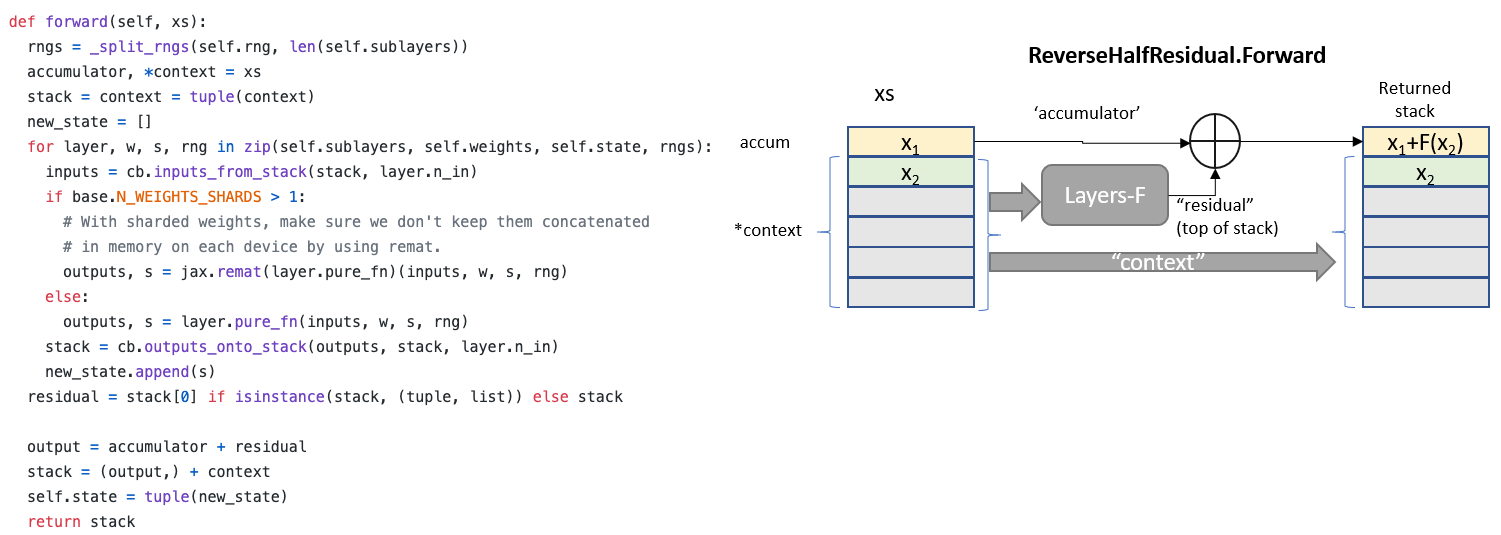</body></html>
<img src = "images/Revnet4.PNG" height="650" width="1600">
<center><b>Figure 10: ReversibleHalfResidual code and diagram </b></center>

Unlike the previous residual function, the value that is added is from the second path rather than the input to the set of sublayers in this layer. Note that the Layers called by the ReversibleHalfResidual forward function are not modified to support reverse functionality. This layer provides them a 'normal' view of the stack and takes care of reverse operation.

Let's try out some of these layers! We'll start with the ones that just operate on the stack, Dup() and Swap().

In [15]:
x1 = np.array([1])
x2 = np.array([5])
# Dup() duplicates the Top of Stack and returns the stack
dl = tl.Dup()
dl(x1)

(array([1]), array([1]))

In [16]:
# ReversibleSwap() duplicates the Top of Stack and returns the stack
sl = tl.ReversibleSwap()
sl([x1, x2])

(array([5]), array([1]))

You are no doubt wondering "How is ReversibleSwap different from Swap?". Good question! Lets look:<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>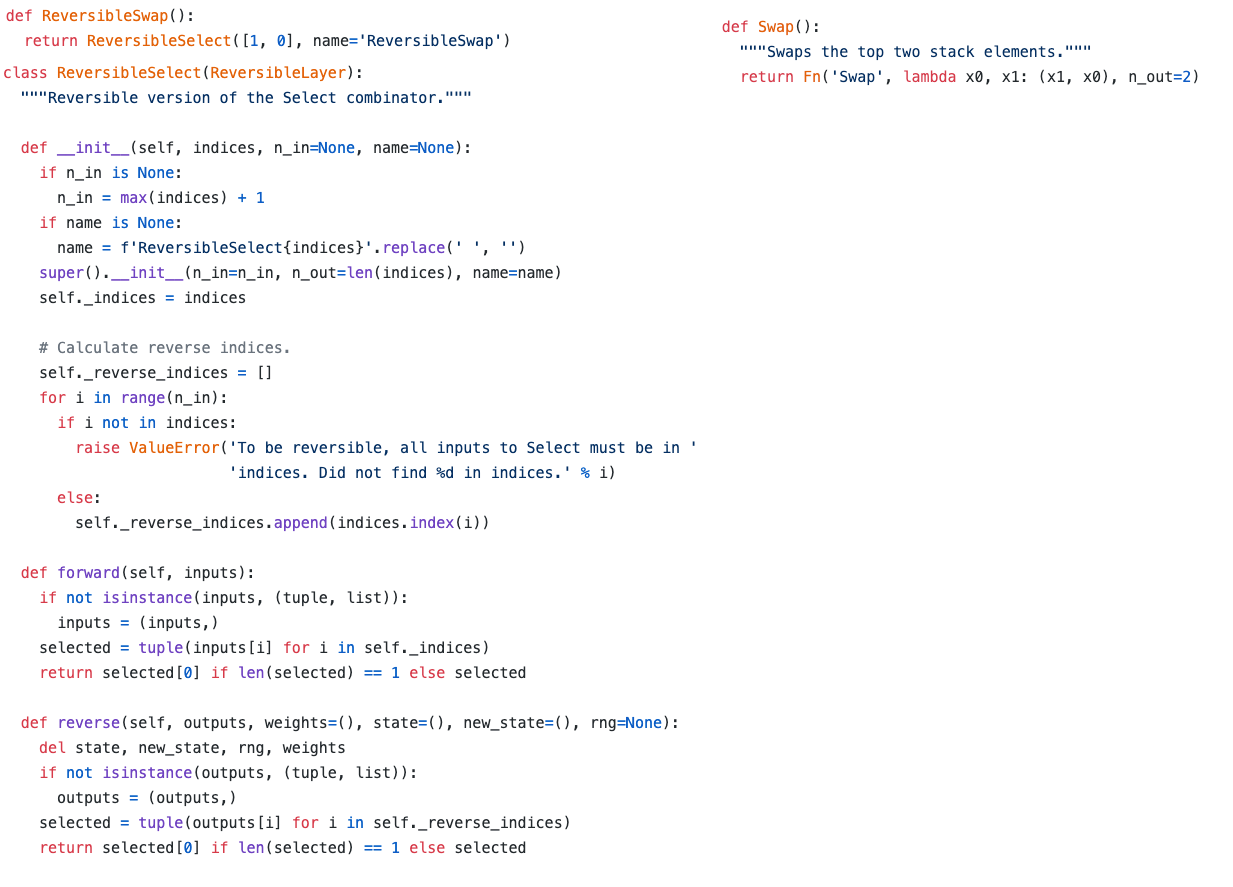</body></html>
<img src = "images/Revnet5.PNG" height="389" width="1000">
<center><b>Figure 11: Two versions of Swap() </b></center>
The ReverseXYZ functions include a "reverse" compliment to their "forward" function that provides the functionality to run in reverse when doing backpropagation. It can also be run in reverse by simply calling 'reverse'.

In [17]:
# Demonstrate reverse swap
print(x1, x2, sl.reverse([x1, x2]))

[1] [5] (array([5]), array([1]))


Let's try ReversibleHalfResidual, First we'll need some layers..

In [18]:
Fl = tl.Fn("F", lambda x0: (2 * x0), n_out=1)
Gl = tl.Fn("G", lambda x0: (10 * x0), n_out=1)

Just a note about ReversibleHalfResidual. As this is written, it resides in the Reformer model and is a layer. It is invoked a bit differently than other layers. Rather than tl.XYZ, it is just ReversibleHalfResidual(layers..) as shown below. This may change in the future.

In [19]:
half_res_F = ReversibleHalfResidual(Fl)
print(type(half_res_F), "\n", half_res_F)

<class 'trax.layers.reversible.ReversibleHalfResidual'> 
 ReversibleHalfResidual_in2_out2[
  Serial[
    F
  ]
]


In [20]:
half_res_F([x1, x1])  # this is going to produce an error - why?

LayerError: Exception passing through layer ReversibleHalfResidual (in pure_fn):
  layer created in file [...]/<ipython-input-19-7e8a712ea261>, line 1
  layer input shapes: [ShapeDtype{shape:(1,), dtype:int64}, ShapeDtype{shape:(1,), dtype:int64}]

  File [...]/trax/layers/base.py, line 707, in __setattr__
    super().__setattr__(attr, value)

  File [...]/trax/layers/base.py, line 454, in weights
    f'Number of weight elements ({len(weights)}) does not equal the '

ValueError: Number of weight elements (0) does not equal the number of sublayers (1) in: ReversibleHalfResidual_in2_out2[
  Serial[

    F
  ]

].

In [ ]:
# we have to initialize the ReversibleHalfResidual layer to let it know what the input is going to look like
half_res_F.init(shapes.signature([x1, x1]))
half_res_F([x1, x1])

The final layer we need is the ReversibleSerial Layer. This is the reversible equivalent of the Serial layer and is used in the same manner to build a sequence of layers.

<a name="2.2"></a>
### Part 2.2  Build a reversible model
We now have all the layers we need to build the model shown below. Let's build it in two parts. First we'll build 'blk' and then a list of blk's. And then 'mod'.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>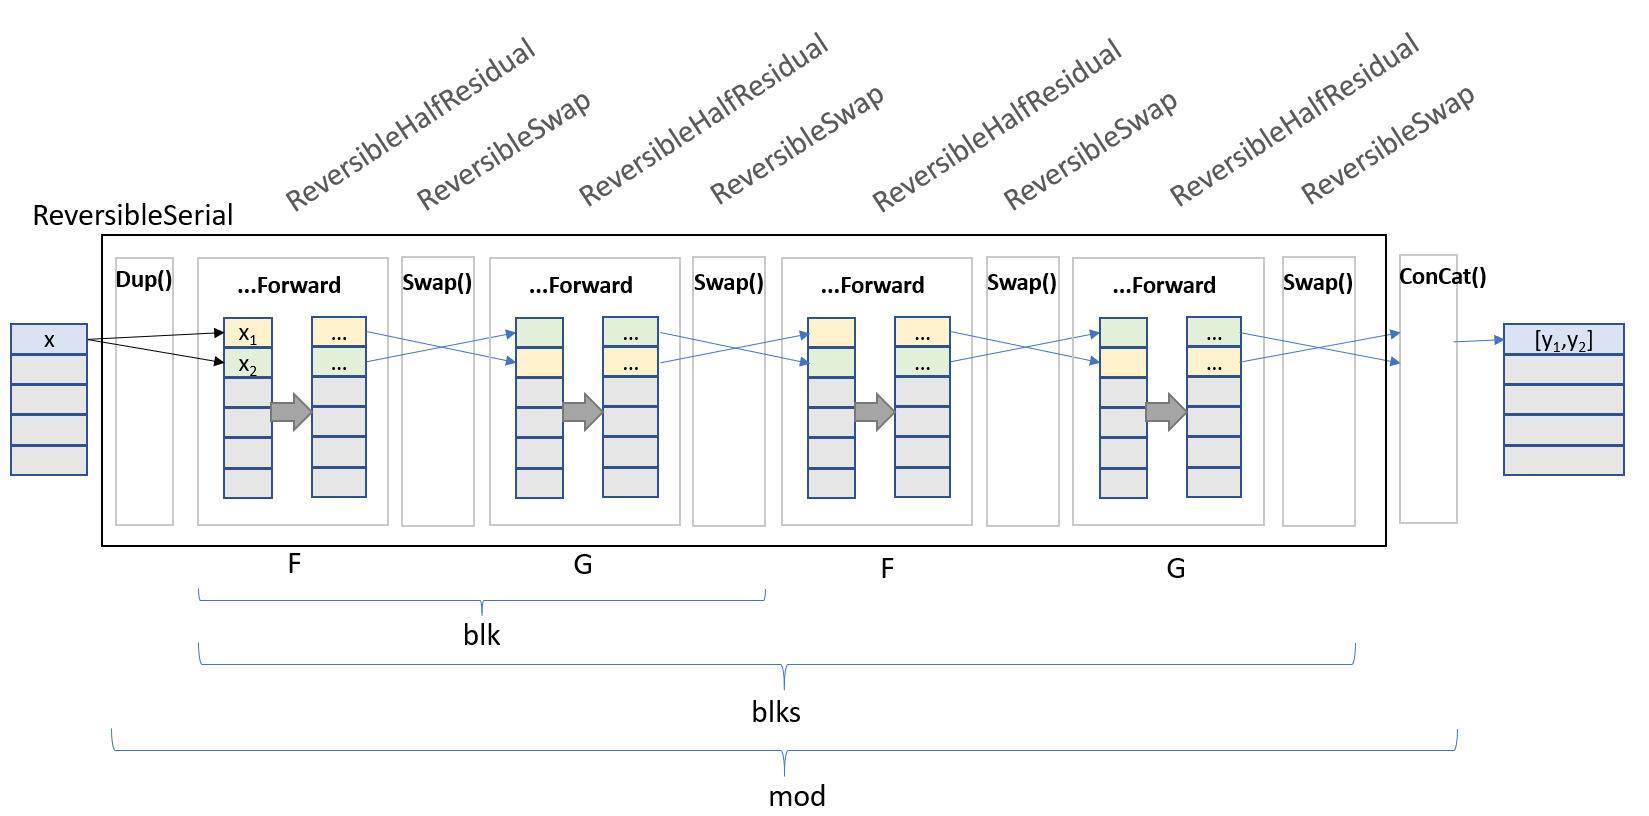</body></html>
<center><img src = "images/Revnet6.PNG" height="800" width="1600"> </center>
<center><b>Figure 12: Reversible Model we will build using Trax components </b></center>

In [ ]:
blk = [  # a list of the 4 layers shown above
    ### START CODE HERE ###
    None,
    None,
    None,
    None,
]
blks = [None, None]
### END CODE HERE ###

In [ ]:
mod = tl.Serial(
    ### START CODE HERE ###
    None,
    None,
    None,
    ### END CODE HERE ###
)
mod

**Expected Output**
```
Serial[
  Dup_out2
  ReversibleHalfResidual_in2_out2[
    Serial[
      F
    ]
  ]
  ReversibleSwap_in2_out2
  ReversibleHalfResidual_in2_out2[
    Serial[
      G
    ]
  ]
  ReversibleSwap_in2_out2
  ReversibleHalfResidual_in2_out2[
    Serial[
      F
    ]
  ]
  ReversibleSwap_in2_out2
  ReversibleHalfResidual_in2_out2[
    Serial[
      G
    ]
  ]
  ReversibleSwap_in2_out2
  Concatenate_in2
]
```

In [ ]:
mod.init(shapes.signature(x1))
out = mod(x1)
out

**Expected Result**
DeviceArray([ 65, 681], dtype=int32)

OK, now you have had a chance to try all the 'Reversible' functions in Trax. On to the Assignment!